# Analysis of Retention Data

### Imports and Load Data

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [254]:
df = pd.read_csv('/home/tom/Documents/ParlayPlay/Data/Retention Data V1 - Raw.csv')
df.columns

Index(['id', 'customer_id', 'is_ftd', 'is_limited', 'dob', 'age',
       'coupon_designation', 'created_est', 'sign_up_time', 'total_amount',
       'contest_count', 'average_entry_amount', 'average_nr_of_picks', 'GGR',
       'deposit_amount', 'withdrawal_amount', 'net_cash', 'First SP Result',
       'Most Frequent State', 'First deposit amount', 'First Deposit Date'],
      dtype='object')

## Cleaning Data

In [138]:
df['coupon_designation'] = df['coupon_designation'].replace('influencer', 'Influencer')

df['created_est'] = pd.to_datetime(df['created_est'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)
df['First Deposit Date'] = pd.to_datetime(df['First Deposit Date'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)

## Analysis of Overall Customer Basis

### Proportion of Customers that are ftd

In [55]:
ftd_counts = df['is_ftd'].value_counts()
ftd_counts

True    73470
Name: is_ftd, dtype: int64

We see that all customers are ftd. This shows that once on the platform, all customers make a deposit. 

In [56]:
coupon_counts = df['coupon_designation'].value_counts()
coupon_counts

referral        47109
Influencer      10429
Paid Digital     6554
Facebook         3923
Programmatic     2072
Apple            1414
Affiliate        1187
Offline           399
TikTok            383
Name: coupon_designation, dtype: int64

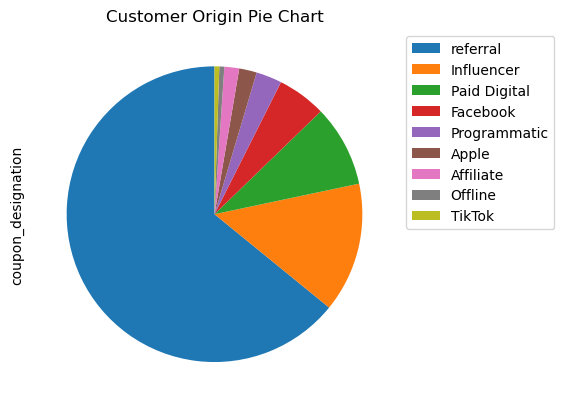

In [123]:
coupon_counts.plot(kind='pie', labels = None, startangle=90, legend =True)
plt.legend(labels = coupon_counts.index, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Customer Origin Pie Chart')
plt.show()

Given all the customers become ftd, it is interesting to see where our customers come from. We see that referral is by far the largest segment and so marketing strategies in this area appear to be working well. However, TikTok brings in the least customers which is surprising given how big a platform it is - especially compared with Facebook. It will be interesting to see the age demographic of our users as, from personal experience in the UK, TikTok is predominantly used by the younger generations, with Facebook reserved for older people. This also highlights that maybe a stronger emphasis may need to be placed on bringing in customers from TikTok.  

In [104]:
df['age'].describe()

count    73470.000000
mean        30.379134
std         10.086923
min         18.000000
25%         23.000000
50%         28.000000
75%         35.000000
max         94.000000
Name: age, dtype: float64

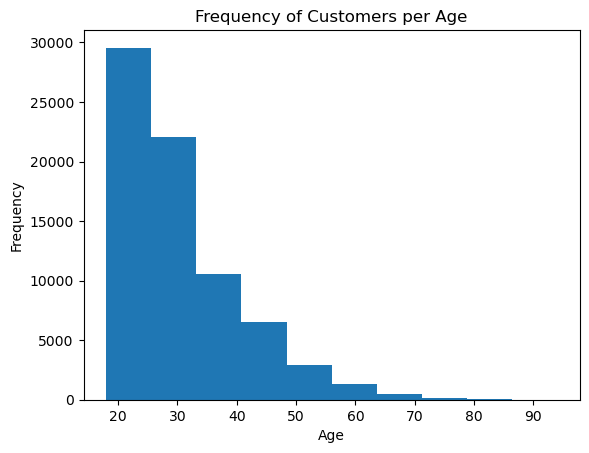

In [122]:
df['age'].plot(kind='hist')
plt.title("Frequency of Customers per Age")
plt.xlabel("Age")
plt.show()

This is not what I was expecting. This shows the demographic of our users is young (early 20s). Perhaps an analysis of the average age per coupon designation will yield an insight. 

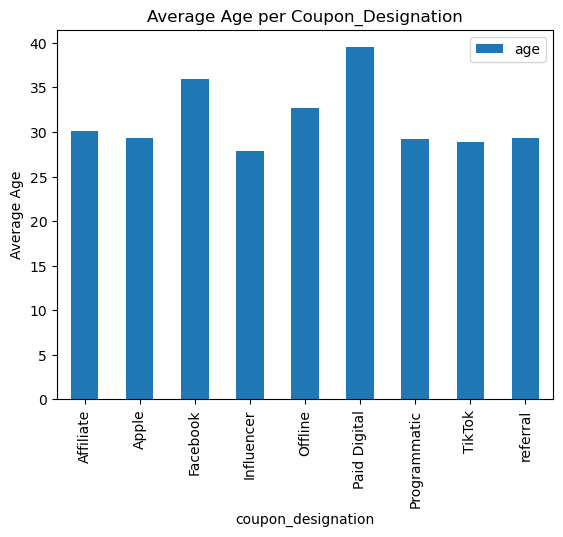

In [124]:
df[['coupon_designation','age']].groupby('coupon_designation').mean().plot(kind='bar')
plt.title("Average Age per Coupon_Designation")
plt.ylabel("Average Age")
plt.show()

This would make sense. The largest proportion of coupon_designation (referral), has one of the lowest average ages. This graph also shows that the age of referral and TikTok (the smallest proportioin of coupon_designation) is roughly the same, highlighting a potentially yet untapped customer source.  

The analysis thus far has given me an understanding of our customer basis. We now move to analysing customer LTV and activity.

## Customer Activity

### Feature Engineering

To analyse LTV and activity, there are a couple of metrics that might be usfeful:

* Time Difference between when first deposit is made and when the account was created
* Want score for how good a customer is, so do net_cash / countest_count (i.e. how much money a customer makes per contest)

In [148]:
# find time difference (in hours)
df['time_diff'] = (df['First Deposit Date'] - df['created_est']).astype('timedelta64[h]')
# find score
df['customer_score'] = df['net_cash'] / df['contest_count']

### Analysis of Levels of Engagement

In [156]:
df['contest_count'].describe()

count    73470.000000
mean        41.675378
std        105.018961
min          0.000000
25%          6.000000
50%         14.000000
75%         35.000000
max       4152.000000
Name: contest_count, dtype: float64

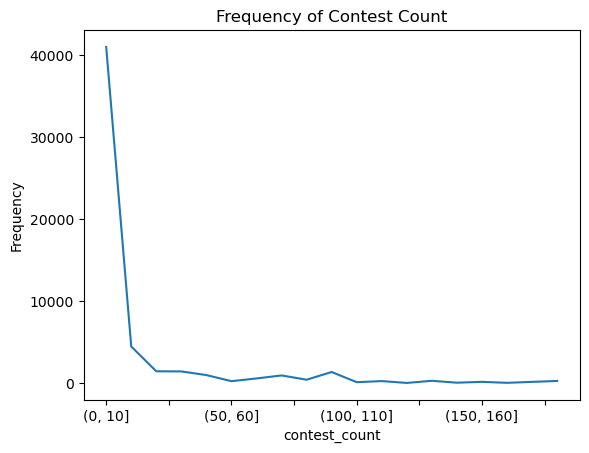

In [252]:
df['contest_count'].groupby(pd.cut(df["contest_count"].value_counts(), np.arange(0, 200, 10))).sum().plot(kind = 'line')
plt.title("Frequency of Contest Count")
plt.ylabel("Frequency")
plt.show()

We see that our data is skewed to the right (mean > median) which would make sense as we will have a few customers who are very active with the platform. The median number of contests, 14, may be a useful benchmark for customer engagement. The line graph above shows that our users predominantly place less than 25 contests and so when analysing our customers, it makes sense to focus more here. 

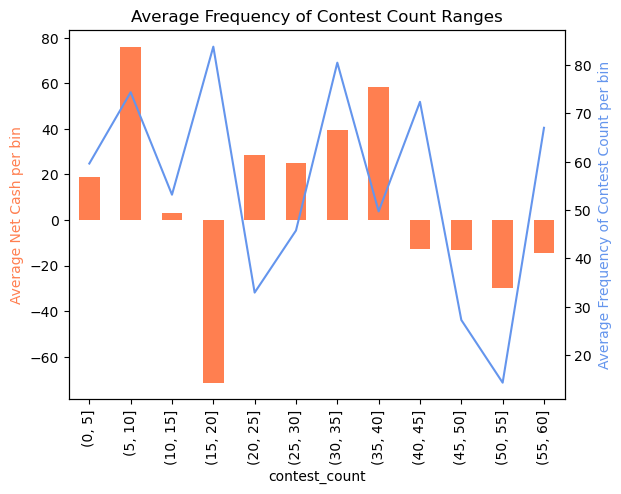

In [253]:
bar_data = df['net_cash'].groupby(pd.cut(df["contest_count"].value_counts(), np.arange(0, 65, 5))).mean()
ax1 = bar_data.plot(kind='bar', color = 'coral', label='Net Cash')
ax1.set_ylabel('Average Net Cash per bin', color = 'coral')

ax2 = ax1.twinx()

line_data = df['contest_count'].groupby(pd.cut(df["contest_count"].value_counts(), np.arange(0, 65, 5))).mean()
line_data.plot(kind='line', ax=ax2, color = 'cornflowerblue', label='Contest Count')
ax2.set_ylabel('Average Frequency of Contest Count per bin', color = 'cornflowerblue')

plt.title("Average Frequency of Contest Count Ranges")
plt.show()

This graph gives us an idea of the most profitable users (for the company). As expected, we see that as the number of contests increases (i.e. the user becomes more involved with the platform), the user wins more as shown by the negative bar graphs in the contest_counts range [40-60]. These customers are likely very involved with the platform. 

Interestingly however, we see that for contest_counts between [5-10], the frequency of these contests increases and so does the net cash so we can identify these customers as our most profitable. These users could potentially be either new or casual users who aren't as skilled as more regular ones. 

That said, with [15-20] contests, we also have a spike in frequency but a dramatic loss of money. This could imply that customers with around [15-20] picks are adept in making good picks which would correspond to regular but not highly active users. 

Between [20-40] is pretty interesting too because as the contest_counts increase (i.e. higher customer engagment), they seem to be getting worse. A thought I had on this was how often do customers receive promotion picks? Could this range be customers moving from solely using free picks to actually spending their own money? Would be interesting to explore this further. 